# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

**Description of the data**
```
/datasets/taxi.csv
Features:
    num_orders - number of orders
```

## Data preparation

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date 

from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

In [4]:
try:
    df = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [6]:
df = df.resample('1H').sum()
display(df.info())
display(df.describe(include='all'))
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000
mean,84.423
std,45.024
min,0.000
25%,54.000
50%,78.000
75%,107.000
max,462.000


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
# we need to replace the zero value to avoid -inf after taking the logarithm
df['num_orders'] = df['num_orders'].replace(0, 1)
df[df['num_orders']==0]

,num_orders
datetime,


**Conclusion**  
After making sure that our data were monotonic, we resampled it.

## Analysis

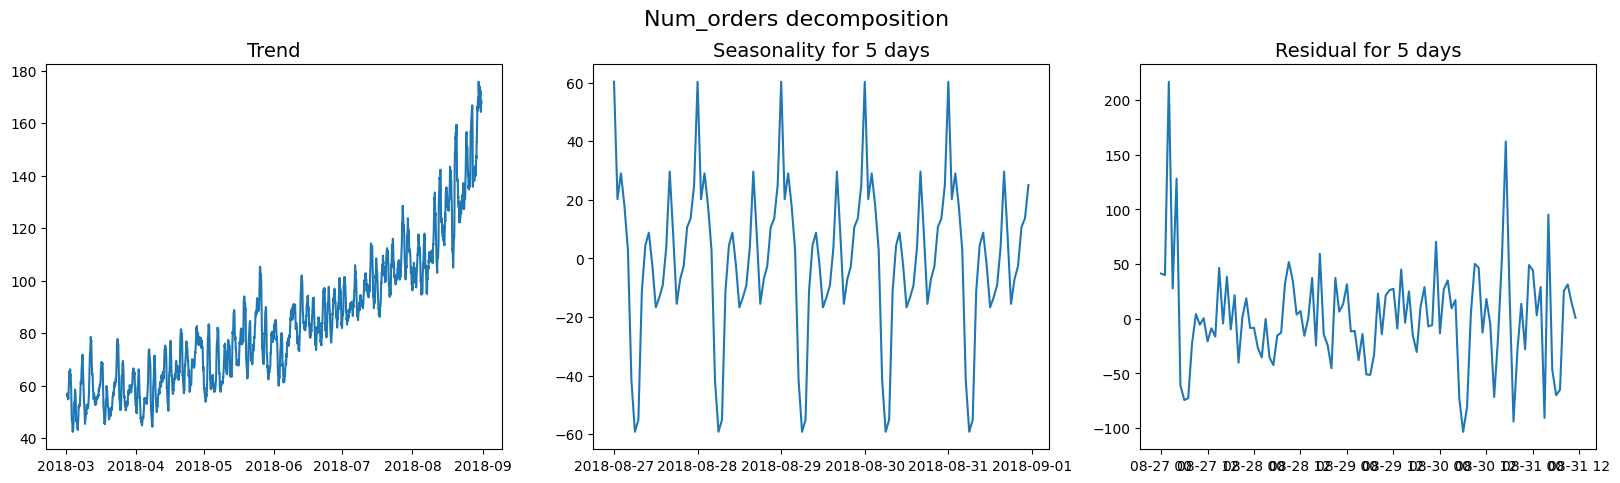

In [8]:
decomposed = seasonal_decompose(df['num_orders'])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('Num_orders decomposition', fontsize=16, y=0.99)
ax[0].plot(decomposed.trend)
ax[0].set_title('Trend', fontsize=14)
ax[1].plot(decomposed.seasonal['2018-08-27':'2018-09'])
ax[1].set_title('Seasonality for 5 days', fontsize=14)
ax[2].plot(decomposed.resid['2018-08-27':'2018-09'])
ax[2].set_title('Residual for 5 days', fontsize=14);

Our series isn't stationary: we have an upward trend and a daily seasonal component.

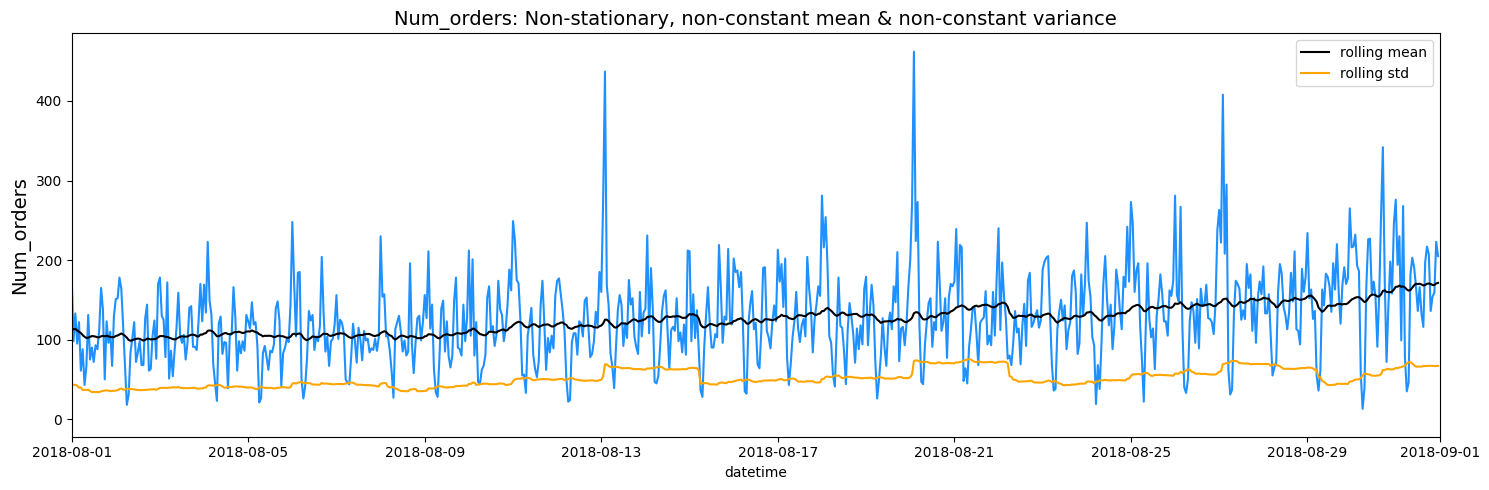

In [9]:
rolling_window = 52

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

sns.lineplot(x=df.index, y=df['num_orders'], ax=ax1, color='dodgerblue')
sns.lineplot(x=df.index, y=df['num_orders'].rolling(rolling_window).mean(), \
             ax=ax1, color='black', label='rolling mean')
sns.lineplot(x=df.index, y=df['num_orders'].rolling(rolling_window).std(), \
             ax=ax1, color='orange', label='rolling std')
ax1.set_title('Num_orders: Non-stationary, non-constant mean & non-constant variance', fontsize=14)
ax1.set_ylabel(ylabel='Num_orders', fontsize=14)
ax1.set_xlim([date(2018, 8, 1), date(2018, 9, 1)])

plt.tight_layout()
plt.show()

In [10]:
#to make the target stationary we made a log transformation to stabilize non-constant variance and
# differenced to stabilize the mean
df['num_orders_log'] = np.log(abs(df['num_orders']))
df['num_orders_log_pred'] = df['num_orders_log'].shift()
df['num_orders_1'] = df['num_orders_log'] - df['num_orders_log_pred']
df.dropna(inplace=True)

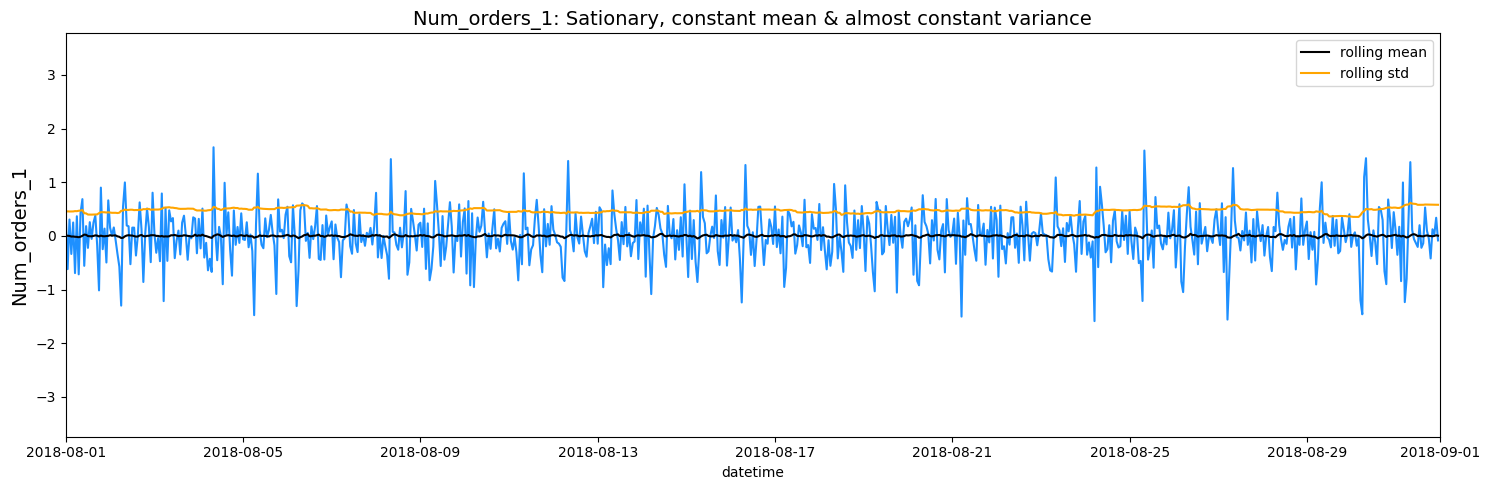

In [11]:
rolling_window = 52
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

sns.lineplot(x=df.index, y=df['num_orders_1'], ax=ax1, color='dodgerblue')
sns.lineplot(x=df.index, y=df['num_orders_1'].rolling(rolling_window).mean(), \
             ax=ax1, color='black', label='rolling mean')
sns.lineplot(x=df.index, y=df['num_orders_1'].rolling(rolling_window).std(), \
             ax=ax1, color='orange', label='rolling std')
ax1.set_title('Num_orders_1: Sationary, constant mean & almost constant variance', fontsize=14)
ax1.set_ylabel(ylabel='Num_orders_1', fontsize=14)
ax1.set_xlim([date(2018, 8, 1), date(2018, 9, 1)])

plt.tight_layout()
plt.show()

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour    
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders_1'].shift(lag)

    df['rolling_mean'] = df['num_orders_1'].shift().rolling(rolling_mean_size).mean()
    return df

In [13]:
df = make_features(df, 7, 7)

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop(['num_orders', 'num_orders_1', 'num_orders_log'], axis=1)
y_train = train['num_orders_1']
X_test = test.drop(['num_orders', 'num_orders_1', 'num_orders_log'], axis=1)
y_test = test['num_orders_1']

tscv = TimeSeriesSplit(n_splits=3) 

In [15]:
X_train

,num_orders_log_pred,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 08:00:00,2.708,3,1,3,8,0.223,0.693,-1.969,-0.428,-0.073,-0.180,-0.378,-0.302
2018-03-01 09:00:00,3.526,3,1,3,9,0.818,0.223,0.693,-1.969,-0.428,-0.073,-0.180,-0.131
2018-03-01 10:00:00,4.234,3,1,3,10,0.708,0.818,0.223,0.693,-1.969,-0.428,-0.073,-0.004
2018-03-01 11:00:00,4.159,3,1,3,11,-0.075,0.708,0.818,0.223,0.693,-1.969,-0.428,-0.004
2018-03-01 12:00:00,4.564,3,1,3,12,0.405,-0.075,0.708,0.818,0.223,0.693,-1.969,0.115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,4.511,8,13,0,9,0.847,-0.526,-0.229,-0.544,-0.161,-0.956,0.470,-0.157
2018-08-13 10:00:00,4.920,8,13,0,10,0.409,0.847,-0.526,-0.229,-0.544,-0.161,-0.956,-0.166
2018-08-13 11:00:00,5.050,8,13,0,11,0.130,0.409,0.847,-0.526,-0.229,-0.544,-0.161,-0.011


**Conclusion**  
Our target variable wasn't stationary, so we made a log transformation to stabilize non-constant variance and differenced it to stabilize the mean.  
We saved the first value so we could reverse the conversion.  
Then we constructed features by shifting the target and splitting the datetime feature into components.

## Model training

In [16]:
def rmse_func(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

rmse = make_scorer(rmse_func, greater_is_better=False)

def fit_score(model, pref, name, params):
    start = time.time()
    if pref != 'cb':
        pipe = Pipeline([('scaler', MinMaxScaler()), (pref, model)])
        model = GridSearchCV(pipe, param_grid=params, cv=tscv, scoring=rmse, verbose=0, refit=True)
        model.fit(X_train, y_train)
        score = abs(model.best_score_)
        best_params = model.best_params_
    elif pref == 'cb':
        grid_search_result = model.grid_search(params, cv=tscv, X=Pool(X_train, y_train))
        score = abs(model.get_best_score()['learn']['RMSE'])
        best_params = grid_search_result['params']
    end = time.time()
    diff = end - start
    return pd.DataFrame([[name, score, diff, best_params]], \
                        columns=['Estimator', 'Best Score', 'Time', 'Params'])


In [17]:
%%time
LinearRegressor = fit_score(LinearRegression(), 'lr', 'Linear Regressor', {})

CPU times: user 158 ms, sys: 53.7 ms, total: 212 ms
Wall time: 46.2 ms


In [18]:
%%time
RandomForest = fit_score(RandomForestRegressor(random_state=42), 'rf', 'Random Forest',
                       {'rf__n_estimators': [5, 10, 20],
                        'rf__max_depth': [3, 5, 10],
                        'rf__min_impurity_decrease': [0.05, 0.25, 0.1]})

CPU times: user 3.38 s, sys: 170 ms, total: 3.55 s
Wall time: 3.08 s


In [19]:
%%time
CatBoost = fit_score(CatBoostRegressor(silent=True, loss_function='RMSE'), 'cb', 'Cat Boost',
                       {'iterations': [50],
                        'depth': [10],
                        'learning_rate': [0.01, 0.05, 0.1],})


bestTest = 0.4166385652
bestIteration = 49

0:	loss: 0.4166386	best: 0.4166386 (0)	total: 626ms	remaining: 1.25s

bestTest = 0.3475543862
bestIteration = 49

1:	loss: 0.3475544	best: 0.3475544 (1)	total: 1.16s	remaining: 580ms

bestTest = 0.3294612301
bestIteration = 49

2:	loss: 0.3294612	best: 0.3294612 (2)	total: 1.77s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.4336446644
bestIteration = 49

Training on fold [1/3]

bestTest = 0.3711403562
bestIteration = 45

Training on fold [2/3]

bestTest = 0.3331869854
bestIteration = 48

CPU times: user 22.1 s, sys: 839 ms, total: 22.9 s
Wall time: 4.12 s


In [20]:
scores = pd.concat([LinearRegressor, RandomForest, CatBoost]).reset_index(drop=True)
scores.style.hide_index()

Estimator,Best Score,Time,Params
Linear Regressor,0.465422,0.045259,{}
Random Forest,0.490619,3.076343,"{'rf__max_depth': 3, 'rf__min_impurity_decrease': 0.05, 'rf__n_estimators': 20}"
Cat Boost,0.283055,4.116452,"{'depth': 10, 'iterations': 50, 'learning_rate': 0.1}"


**Conclusion**  
We trained several models using the RMSE score and GridSearchCV to look for the best hyperparameters. The lower the RMSE, the better is the model, so our best is the CatBoost Regressor.

## Model testing

In [21]:
final_model = CatBoostRegressor(random_seed=42, silent=True, loss_function='RMSE',\
                                **scores[scores['Estimator']=='Cat Boost']['Params'].values[0])
final_model.fit(X=Pool(X_train, y_train))

test['pred_1'] = final_model.predict(X_test)
test['pred_log'] = test['num_orders_log_pred'] + test['pred_1']
test['pred'] = np.exp(test['pred_log'])

cb_true_rmse = rmse_func(test['num_orders'], test['pred'])
print(f'RMSE score for best CatBoostRegressor model on test dataframe: {cb_true_rmse:.2f}')

RMSE score for best CatBoostRegressor model on test dataframe: 45.06


In [22]:
test['prev'] = test['num_orders'].shift()
test['prev'][0] = train['num_orders'][-1]

baseline_rmse = rmse_func(test['num_orders'], test['prev'])
print(f'RMSE score for a baseline model using the previous value as a predictor: {baseline_rmse:.2f}')

RMSE score for a baseline model using the previous value as a predictor: 58.86


In [23]:
test['median'] = test['num_orders'].median()

baseline_rmse = rmse_func(test['num_orders'], test['median'])
print(f'RMSE score for a baseline model using the median as a predictor: {baseline_rmse:.2f}')

RMSE score for a baseline model using the median as a predictor: 58.73


**Conclusion**  
In this project, we explored several models using the RMSE score and GridSearchCV to look for the best hyperparameters. Our best model was the CatBoost Regressor.